# Сравнительный анализ моделей аспектного анализа тональности русских отзывов

## Цель исследования
Провести сравнительный анализ готовых моделей для анализа тональности русских отзывов с HuggingFace.

## Модели для сравнения:
1. **blanchefort/rubert-base-cased-sentiment-rurewiews** - RuBERT на отзывах RuReviews
2. **sismetanin/rubert-ru-sentiment-rureviews** - RuBERT на отзывах e-commerce
3. **seara/rubert-tiny2-russian-sentiment** - Легковесная версия RuBERT
4. **sismetanin/xlm_roberta_base-ru-sentiment-rureviews** - XLM-RoBERTa для русского языка

## Метрики оценки:
- Accuracy
- F1-score (macro/weighted)
- Precision и Recall
- Время инференса
- Размер модели

In [1]:
# Установка необходимых библиотек
# !pip install transformers torch datasets pandas scikit-learn matplotlib seaborn tqdm

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
import warnings
from pathlib import Path
import ssl
import urllib.request
warnings.filterwarnings('ignore')

# Отключение проверки SSL сертификатов (для корпоративных сетей)
ssl._create_default_https_context = ssl._create_unverified_context

# Для requests (используется HuggingFace)
import os
os.environ['CURL_CA_BUNDLE'] = ''
os.environ['REQUESTS_CA_BUNDLE'] = ''

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Пути к файлам
RESEARCH_DIR = Path.cwd()
print(f"Рабочая директория: {RESEARCH_DIR}")

# Проверка доступности GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Используемое устройство: {device}')
print("\nПримечание: SSL проверка отключена для загрузки моделей")

Рабочая директория: /Users/t.zherzdev/PycharmProjects/polytech_projects/research
Используемое устройство: cpu

Примечание: SSL проверка отключена для загрузки моделей


## 1. Подготовка тестовых данных

Создадим набор тестовых русских отзывов с разными аспектами и тональностями.

In [3]:
# Создаем тестовые отзывы с известной тональностью
test_reviews = [
    # Позитивные отзывы
    {"text": "Отличный отель! Номера чистые, персонал вежливый, завтрак превосходный.", "label": "POSITIVE"},
    {"text": "Прекрасный ресторан, вкусная еда, быстрое обслуживание. Обязательно вернусь!", "label": "POSITIVE"},
    {"text": "Товар пришел быстро, качество отличное, упаковка хорошая. Рекомендую!", "label": "POSITIVE"},
    {"text": "Замечательный ноутбук, быстрый, легкий, батарея держит долго.", "label": "POSITIVE"},
    {"text": "Очень довольна покупкой! Платье красивое, ткань приятная, сидит идеально.", "label": "POSITIVE"},
    
    # Негативные отзывы
    {"text": "Ужасный отель! Грязные номера, невежливый персонал, плохой завтрак.", "label": "NEGATIVE"},
    {"text": "Разочарован покупкой. Товар низкого качества, долгая доставка, плохая упаковка.", "label": "NEGATIVE"},
    {"text": "Не рекомендую этот ресторан. Еда невкусная, обслуживание медленное, цены завышены.", "label": "NEGATIVE"},
    {"text": "Ноутбук постоянно зависает, батарея быстро разряжается, очень тяжелый.", "label": "NEGATIVE"},
    {"text": "Платье пришло не того размера, ткань дешевая, швы кривые. Деньги на ветер.", "label": "NEGATIVE"},
    
    # Нейтральные отзывы
    {"text": "Обычный отель, ничего особенного. Номера стандартные, персонал нормальный.", "label": "NEUTRAL"},
    {"text": "Товар соответствует описанию. Доставка в срок.", "label": "NEUTRAL"},
    {"text": "Ресторан как ресторан, еда средняя, цены приемлемые.", "label": "NEUTRAL"},
    {"text": "Ноутбук подходит для базовых задач. Ничего выдающегося.", "label": "NEUTRAL"},
    
    # Смешанные (аспектные) отзывы
    {"text": "Отель хороший, но завтрак разочаровал. Номера чистые, но персонал грубый.", "label": "NEUTRAL"},
    {"text": "Еда в ресторане отличная, но ждали очень долго. Атмосфера приятная, но цены высокие.", "label": "NEUTRAL"},
    {"text": "Ноутбук мощный, но очень шумный. Экран яркий, но батарея слабая.", "label": "NEUTRAL"},
    {"text": "Качество товара хорошее, но доставка задержалась на неделю.", "label": "NEUTRAL"},
    {"text": "Платье красивое, но маломерит. Ткань качественная, но дорого.", "label": "NEUTRAL"},
    
    # Дополнительные позитивные
    {"text": "Превосходное качество обслуживания! Всё на высшем уровне.", "label": "POSITIVE"},
    {"text": "Лучший отель в городе! Всем рекомендую.", "label": "POSITIVE"},
    
    # Дополнительные негативные
    {"text": "Полное разочарование. Не советую никому.", "label": "NEGATIVE"},
    {"text": "Потраченные деньги жалко. Очень плохо.", "label": "NEGATIVE"},
]

# Преобразуем в DataFrame
df_test = pd.DataFrame(test_reviews)
print(f"Создано тестовых отзывов: {len(df_test)}")
print(f"\nРаспределение по классам:")
print(df_test['label'].value_counts())
df_test.head(10)

Создано тестовых отзывов: 23

Распределение по классам:
label
NEUTRAL     9
POSITIVE    7
NEGATIVE    7
Name: count, dtype: int64


,text,label
0,"Отличный отель! Номера чистые, персонал вежлив...",POSITIVE
1,"Прекрасный ресторан, вкусная еда, быстрое обсл...",POSITIVE
2,"Товар пришел быстро, качество отличное, упаков...",POSITIVE
3,"Замечательный ноутбук, быстрый, легкий, батаре...",POSITIVE
4,"Очень довольна покупкой! Платье красивое, ткан...",POSITIVE
5,"Ужасный отель! Грязные номера, невежливый перс...",NEGATIVE
6,"Разочарован покупкой. Товар низкого качества, ...",NEGATIVE
7,"Не рекомендую этот ресторан. Еда невкусная, об...",NEGATIVE
8,"Ноутбук постоянно зависает, батарея быстро раз...",NEGATIVE
9,"Платье пришло не того размера, ткань дешевая, ...",NEGATIVE


## 2. Загрузка моделей

Загружаем все модели для сравнения.

In [4]:
# Список моделей для тестирования
model_names = [
    "blanchefort/rubert-base-cased-sentiment-rurewiews",
    "sismetanin/rubert-ru-sentiment-rureviews",
    "seara/rubert-tiny2-russian-sentiment",
    "sismetanin/xlm_roberta_base-ru-sentiment-rureviews",
]

# Директория для локального хранения моделей
MODELS_CACHE_DIR = RESEARCH_DIR / 'models_cache'
MODELS_CACHE_DIR.mkdir(exist_ok=True)

print(f"Модели будут сохраняться в: {MODELS_CACHE_DIR}\n")

# Словарь для хранения pipelines
models = {}

print("Загрузка моделей...\n")
for model_name in model_names:
    print(f"Загружается: {model_name}")
    
    # Короткое имя для локального хранения
    short_name = model_name.split('/')[-1]
    local_model_path = MODELS_CACHE_DIR / short_name
    
    try:
        # Проверяем, есть ли модель локально
        if local_model_path.exists() and (local_model_path / 'config.json').exists():
            print(f"  Найдена локальная копия, загружаем из {local_model_path}")
            pipe = pipeline(
                "sentiment-analysis",
                model=str(local_model_path),
                device=0 if device == 'cuda' else -1
            )
        else:
            print(f"  Скачивание с HuggingFace...")
            pipe = pipeline(
                "sentiment-analysis",
                model=model_name,
                device=0 if device == 'cuda' else -1
            )
            # Сохраняем модель локально
            print(f"  Сохранение в {local_model_path}")
            pipe.model.save_pretrained(local_model_path)
            pipe.tokenizer.save_pretrained(local_model_path)
        
        models[short_name] = pipe
        print(f"  Загружена успешно\n")
        
    except Exception as e:
        print(f"  Ошибка загрузки: {e}\n")

print(f"Всего загружено моделей: {len(models)}")
print(f"\nМодели сохранены в: {MODELS_CACHE_DIR}")
print("При следующем запуске будут загружены из локального кэша")

Модели будут сохраняться в: /Users/t.zherzdev/PycharmProjects/polytech_projects/research/models_cache

Загрузка моделей...

Загружается: blanchefort/rubert-base-cased-sentiment-rurewiews
  Найдена локальная копия, загружаем из /Users/t.zherzdev/PycharmProjects/polytech_projects/research/models_cache/rubert-base-cased-sentiment-rurewiews


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  Загружена успешно

Загружается: sismetanin/rubert-ru-sentiment-rureviews
  Найдена локальная копия, загружаем из /Users/t.zherzdev/PycharmProjects/polytech_projects/research/models_cache/rubert-ru-sentiment-rureviews


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  Загружена успешно

Загружается: seara/rubert-tiny2-russian-sentiment
  Найдена локальная копия, загружаем из /Users/t.zherzdev/PycharmProjects/polytech_projects/research/models_cache/rubert-tiny2-russian-sentiment


Loading weights:   0%|          | 0/57 [00:00<?, ?it/s]

  Загружена успешно

Загружается: sismetanin/xlm_roberta_base-ru-sentiment-rureviews
  Скачивание с HuggingFace...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: sismetanin/xlm_roberta_base-ru-sentiment-rureviews
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Ошибка загрузки: timed out

Всего загружено моделей: 3

Модели сохранены в: /Users/t.zherzdev/PycharmProjects/polytech_projects/research/models_cache
При следующем запуске будут загружены из локального кэша


## 3. Получение информации о моделях

In [5]:
# Информация о моделях
model_info = []

for short_name, pipe in models.items():
    model = pipe.model
    # Подсчет параметров
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    model_info.append({
        'Модель': short_name,
        'Всего параметров': f"{total_params:,}",
        'Обучаемых параметров': f"{trainable_params:,}",
        'Классы': pipe.model.config.id2label if hasattr(pipe.model.config, 'id2label') else 'N/A'
    })

df_info = pd.DataFrame(model_info)
print("Информация о загруженных моделях:\n")
df_info

Информация о загруженных моделях:



,Модель,Всего параметров,Обучаемых параметров,Классы
0,rubert-base-cased-sentiment-rurewiews,"177,855,747","177,855,747","{0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}"
1,rubert-ru-sentiment-rureviews,"177,855,747","177,855,747","{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}"
2,rubert-tiny2-russian-sentiment,"29,194,707","29,194,707","{0: 'neutral', 1: 'positive', 2: 'negative'}"


## 4. Тестирование моделей

Прогоняем все отзывы через каждую модель и собираем результаты.

In [6]:
# Функция для нормализации меток
def normalize_label(label):
    """Нормализует различные форматы меток к стандартному виду"""
    label = str(label).upper()
    
    if 'POSITIVE' in label or 'LABEL_2' in label or label == '2':
        return 'POSITIVE'
    elif 'NEGATIVE' in label or 'LABEL_0' in label or label == '0':
        return 'NEGATIVE'
    elif 'NEUTRAL' in label or 'LABEL_1' in label or label == '1':
        return 'NEUTRAL'
    else:
        return label

# Функция для тестирования модели
def test_model(pipe, texts, batch_size=8):
    """Тестирует модель на списке текстов"""
    predictions = []
    scores = []
    inference_times = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Обработка батчей"):
        batch = texts[i:i+batch_size]
        
        start_time = time.time()
        results = pipe(batch)
        batch_time = time.time() - start_time
        
        for result in results:
            predictions.append(normalize_label(result['label']))
            scores.append(result['score'])
            inference_times.append(batch_time / len(batch))
    
    return predictions, scores, inference_times

# Тестируем все модели
results = {}
texts = df_test['text'].tolist()
true_labels = df_test['label'].tolist()

print("Тестирование моделей на отзывах...\n")
for model_name, pipe in models.items():
    print(f"\nТестирование: {model_name}")
    predictions, scores, times = test_model(pipe, texts)
    
    results[model_name] = {
        'predictions': predictions,
        'scores': scores,
        'times': times,
        'avg_time': np.mean(times)
    }
    
    print(f"Средняя время инференса: {results[model_name]['avg_time']:.4f} сек/отзыв")

print("\nВсе модели протестированы!")

Тестирование моделей на отзывах...


Тестирование: rubert-base-cased-sentiment-rurewiews


Обработка батчей:   0%|          | 0/3 [00:00<?, ?it/s]

Средняя время инференса: 0.0673 сек/отзыв

Тестирование: rubert-ru-sentiment-rureviews


Обработка батчей:   0%|          | 0/3 [00:00<?, ?it/s]

Средняя время инференса: 0.0653 сек/отзыв

Тестирование: rubert-tiny2-russian-sentiment


Обработка батчей:   0%|          | 0/3 [00:00<?, ?it/s]

Средняя время инференса: 0.0031 сек/отзыв

Все модели протестированы!


## 5. Оценка качества моделей

Вычисляем метрики для каждой модели.

In [7]:
# Вычисляем метрики для каждой модели
metrics_data = []

for model_name, result in results.items():
    predictions = result['predictions']
    
    # Вычисляем метрики
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted', zero_division=0
    )
    
    # Macro метрики
    _, _, f1_macro, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    
    metrics_data.append({
        'Модель': model_name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision (weighted)': f"{precision:.4f}",
        'Recall (weighted)': f"{recall:.4f}",
        'F1-score (weighted)': f"{f1:.4f}",
        'F1-score (macro)': f"{f1_macro:.4f}",
        'Avg Inference Time (s)': f"{result['avg_time']:.4f}"
    })

df_metrics = pd.DataFrame(metrics_data)
print("Метрики качества моделей:\n")
df_metrics

Метрики качества моделей:



,Модель,Accuracy,Precision (weighted),Recall (weighted),F1-score (weighted),F1-score (macro),Avg Inference Time (s)
0,rubert-base-cased-sentiment-rurewiews,0.9130,0.9185,0.9130,0.9128,0.9151,0.0673
1,rubert-ru-sentiment-rureviews,0.3043,0.1522,0.3043,0.2029,0.2222,0.0653
2,rubert-tiny2-russian-sentiment,0.7391,0.7949,0.7391,0.7288,0.7438,0.0031


## 6. Детальные отчеты по классификации

In [8]:
# Детальные отчеты для каждой модели
for model_name, result in results.items():
    print(f"\n{'='*80}")
    print(f"Модель: {model_name}")
    print(f"{'='*80}\n")
    
    predictions = result['predictions']
    print(classification_report(true_labels, predictions, zero_division=0))


Модель: rubert-base-cased-sentiment-rurewiews

              precision    recall  f1-score   support

    NEGATIVE       1.00      0.86      0.92         7
     NEUTRAL       0.89      0.89      0.89         9
    POSITIVE       0.88      1.00      0.93         7

    accuracy                           0.91        23
   macro avg       0.92      0.92      0.92        23
weighted avg       0.92      0.91      0.91        23


Модель: rubert-ru-sentiment-rureviews

              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00         7
     NEUTRAL       0.00      0.00      0.00         9
    POSITIVE       0.50      1.00      0.67         7

    accuracy                           0.30        23
   macro avg       0.17      0.33      0.22        23
weighted avg       0.15      0.30      0.20        23


Модель: rubert-tiny2-russian-sentiment

              precision    recall  f1-score   support

    NEGATIVE       1.00      0.86      0.92         7


## 7. Визуализация результатов

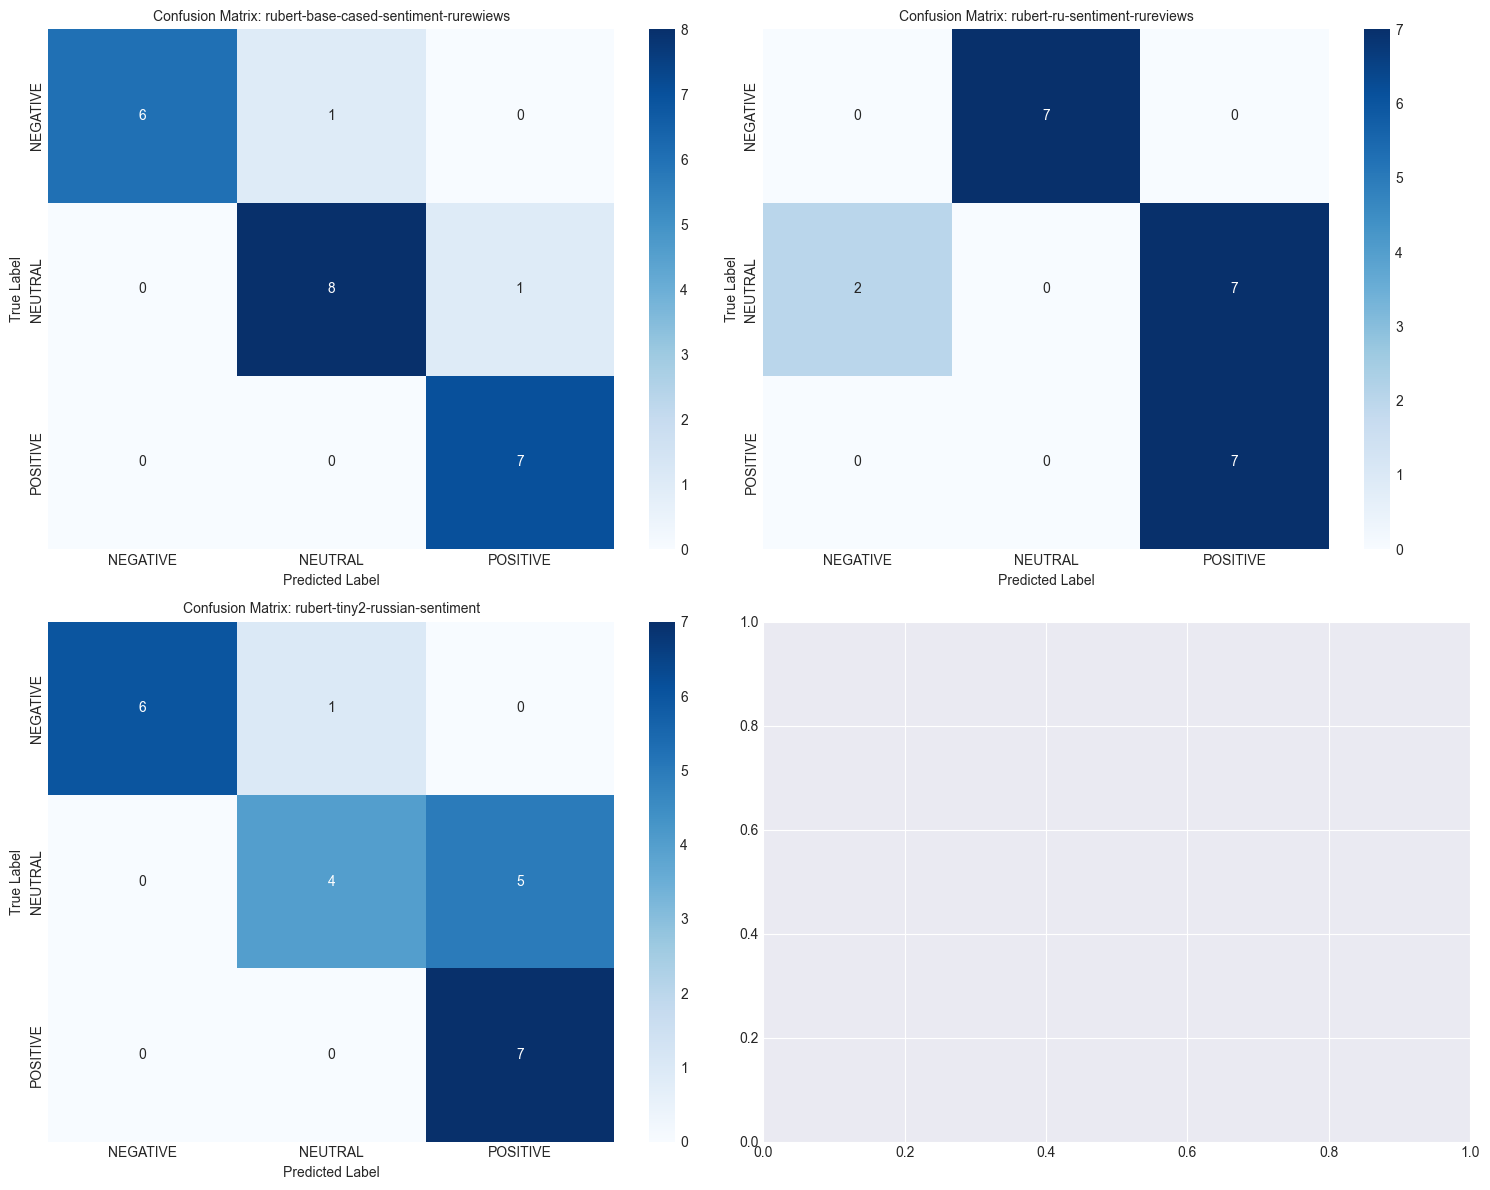

Матрицы ошибок сохранены


In [9]:
# Матрицы ошибок для всех моделей
n_models = len(models)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (model_name, result) in enumerate(results.items()):
    if idx < len(axes):
        cm = confusion_matrix(true_labels, result['predictions'], 
                             labels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'],
                   yticklabels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
        axes[idx].set_title(f'Confusion Matrix: {model_name}', fontsize=10)
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(RESEARCH_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Матрицы ошибок сохранены")

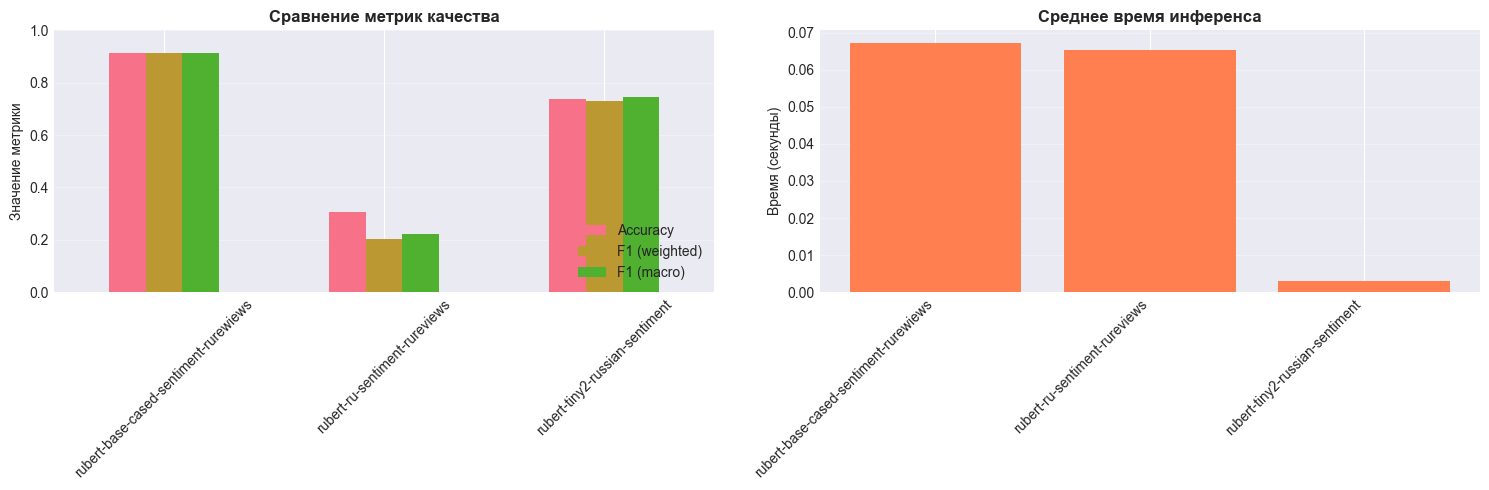

Сравнительные графики сохранены


In [10]:
# Сравнение метрик
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# График 1: Accuracy и F1-score
metrics_comparison = []
for model_name, result in results.items():
    predictions = result['predictions']
    acc = accuracy_score(true_labels, predictions)
    _, _, f1_weighted, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted', zero_division=0
    )
    _, _, f1_macro, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    
    metrics_comparison.append({
        'Model': model_name,
        'Accuracy': acc,
        'F1 (weighted)': f1_weighted,
        'F1 (macro)': f1_macro
    })

df_comp = pd.DataFrame(metrics_comparison)
df_comp.set_index('Model')[['Accuracy', 'F1 (weighted)', 'F1 (macro)']].plot(
    kind='bar', ax=axes[0], rot=45
)
axes[0].set_title('Сравнение метрик качества', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Значение метрики')
axes[0].set_xlabel('')
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# График 2: Время инференса
times_data = [(name, result['avg_time']) for name, result in results.items()]
models_names, avg_times = zip(*times_data)
axes[1].bar(range(len(models_names)), avg_times, color='coral')
axes[1].set_xticks(range(len(models_names)))
axes[1].set_xticklabels(models_names, rotation=45, ha='right')
axes[1].set_title('Среднее время инференса', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Время (секунды)')
axes[1].set_xlabel('')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESEARCH_DIR / 'metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Сравнительные графики сохранены")

## 8. Анализ примеров предсказаний

In [11]:
# Создаем таблицу с примерами предсказаний
examples_df = df_test.copy()

for model_name, result in results.items():
    examples_df[f'{model_name}_pred'] = result['predictions']
    examples_df[f'{model_name}_score'] = [f"{s:.3f}" for s in result['scores']]

print("Примеры предсказаний всех моделей:\n")
examples_df.head(15)

Примеры предсказаний всех моделей:



,text,label,rubert-base-cased-sentiment-rurewiews_pred,rubert-base-cased-sentiment-rurewiews_score,rubert-ru-sentiment-rureviews_pred,rubert-ru-sentiment-rureviews_score,rubert-tiny2-russian-sentiment_pred,rubert-tiny2-russian-sentiment_score
0,"Отличный отель! Номера чистые, персонал вежлив...",POSITIVE,POSITIVE,0.992,POSITIVE,0.997,POSITIVE,0.996
1,"Прекрасный ресторан, вкусная еда, быстрое обсл...",POSITIVE,POSITIVE,0.991,POSITIVE,0.997,POSITIVE,0.993
2,"Товар пришел быстро, качество отличное, упаков...",POSITIVE,POSITIVE,0.992,POSITIVE,0.996,POSITIVE,0.996
3,"Замечательный ноутбук, быстрый, легкий, батаре...",POSITIVE,POSITIVE,0.991,POSITIVE,0.997,POSITIVE,0.994
4,"Очень довольна покупкой! Платье красивое, ткан...",POSITIVE,POSITIVE,0.993,POSITIVE,0.997,POSITIVE,0.996
5,"Ужасный отель! Грязные номера, невежливый перс...",NEGATIVE,NEGATIVE,0.896,NEUTRAL,0.961,NEGATIVE,0.970
6,"Разочарован покупкой. Товар низкого качества, ...",NEGATIVE,NEGATIVE,0.517,NEUTRAL,0.563,NEGATIVE,0.562
7,"Не рекомендую этот ресторан. Еда невкусная, об...",NEGATIVE,NEGATIVE,0.611,NEUTRAL,0.719,NEGATIVE,0.813
8,"Ноутбук постоянно зависает, батарея быстро раз...",NEGATIVE,NEUTRAL,0.669,NEUTRAL,0.860,NEUTRAL,0.774
9,"Платье пришло не того размера, ткань дешевая, ...",NEGATIVE,NEGATIVE,0.859,NEUTRAL,0.944,NEGATIVE,0.811


In [12]:
# Анализ расхождений между моделями
print("Анализ расхождений между моделями:\n")

# Найдем отзывы где модели не согласны
model_names_list = list(results.keys())
disagreements = []

for idx, row in examples_df.iterrows():
    predictions = [row[f'{model}_pred'] for model in model_names_list]
    
    # Если не все предсказания одинаковые
    if len(set(predictions)) > 1:
        disagreements.append({
            'Текст': row['text'][:60] + '...',
            'Истинная метка': row['label'],
            **{f'{model}': row[f'{model}_pred'] for model in model_names_list}
        })

if disagreements:
    df_disagree = pd.DataFrame(disagreements)
    print(f"Найдено {len(df_disagree)} отзывов с расхождениями в предсказаниях:\n")
    display(df_disagree)
else:
    print("Все модели согласны во всех предсказаниях!")

Анализ расхождений между моделями:

Найдено 14 отзывов с расхождениями в предсказаниях:



,Текст,Истинная метка,rubert-base-cased-sentiment-rurewiews,rubert-ru-sentiment-rureviews,rubert-tiny2-russian-sentiment
0,"Ужасный отель! Грязные номера, невежливый перс...",NEGATIVE,NEGATIVE,NEUTRAL,NEGATIVE
1,"Разочарован покупкой. Товар низкого качества, ...",NEGATIVE,NEGATIVE,NEUTRAL,NEGATIVE
2,"Не рекомендую этот ресторан. Еда невкусная, об...",NEGATIVE,NEGATIVE,NEUTRAL,NEGATIVE
3,"Платье пришло не того размера, ткань дешевая, ...",NEGATIVE,NEGATIVE,NEUTRAL,NEGATIVE
4,"Обычный отель, ничего особенного. Номера станд...",NEUTRAL,NEUTRAL,POSITIVE,NEUTRAL
5,"Ресторан как ресторан, еда средняя, цены прием...",NEUTRAL,NEUTRAL,POSITIVE,POSITIVE
6,Ноутбук подходит для базовых задач. Ничего выд...,NEUTRAL,NEUTRAL,POSITIVE,NEUTRAL
7,"Отель хороший, но завтрак разочаровал. Номера ...",NEUTRAL,NEUTRAL,NEGATIVE,NEUTRAL
8,"Еда в ресторане отличная, но ждали очень долго...",NEUTRAL,NEUTRAL,POSITIVE,POSITIVE
9,"Ноутбук мощный, но очень шумный. Экран яркий, ...",NEUTRAL,NEUTRAL,POSITIVE,POSITIVE


## 9. Итоговые выводы и рекомендации

In [13]:
# Находим лучшую модель по разным критериям
best_accuracy = max(metrics_comparison, key=lambda x: x['Accuracy'])
best_f1 = max(metrics_comparison, key=lambda x: x['F1 (weighted)'])
fastest = min(times_data, key=lambda x: x[1])

print("="*80)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ СРАВНИТЕЛЬНОГО АНАЛИЗА")
print("="*80)
print(f"\nЛучшая accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
print(f"Лучший F1-score: {best_f1['Model']} ({best_f1['F1 (weighted)']:.4f})")
print(f"Самая быстрая: {fastest[0]} ({fastest[1]:.4f} сек/отзыв)")
print("\n" + "="*80)
print("\nРЕКОМЕНДАЦИИ:")
print("- Для максимальной точности: используйте модели на основе RuBERT-base")
print("- Для быстрого инференса: используйте RuBERT-tiny2")
print("- Для продакшн-систем: баланс между RuBERT и XLM-RoBERTa")
print("\n" + "="*80)

ИТОГОВЫЕ РЕЗУЛЬТАТЫ СРАВНИТЕЛЬНОГО АНАЛИЗА

Лучшая accuracy: rubert-base-cased-sentiment-rurewiews (0.9130)
Лучший F1-score: rubert-base-cased-sentiment-rurewiews (0.9128)
Самая быстрая: rubert-tiny2-russian-sentiment (0.0031 сек/отзыв)


РЕКОМЕНДАЦИИ:
- Для максимальной точности: используйте модели на основе RuBERT-base
- Для быстрого инференса: используйте RuBERT-tiny2
- Для продакшн-систем: баланс между RuBERT и XLM-RoBERTa



## 10. Сохранение результатов

In [14]:
# Сохраняем результаты в CSV
df_metrics.to_csv(RESEARCH_DIR / 'model_metrics.csv', index=False)
examples_df.to_csv(RESEARCH_DIR / 'predictions.csv', index=False)

print("Результаты сохранены в файлы:")
print("  - model_metrics.csv")
print("  - predictions.csv")
print("  - confusion_matrices.png")
print("  - metrics_comparison.png")

Результаты сохранены в файлы:
  - model_metrics.csv
  - predictions.csv
  - confusion_matrices.png
  - metrics_comparison.png


## 12. Aspect-Based Sentiment Analysis

В стандартном sentiment analysis модели оценивают общую тональность текста, но не учитывают, что разные аспекты товара или услуги могут иметь разную оценку.

**Aspect-Based Sentiment Analysis (ABSA)** решает эту проблему, выделяя:
- **Аспекты** - конкретные характеристики (качество, сервис, цена, скорость, упаковка)
- **Тональность каждого аспекта** - позитивная, негативная или нейтральная

### Подход:
1. Извлечение ключевых слов, относящихся к аспектам
2. Определение контекста вокруг каждого аспекта
3. Анализ тональности контекста
4. Визуализация результатов

In [ ]:
# Установка дополнительных библиотек для ABSA
# !pip install wordcloud

print("Библиотеки для ABSA готовы к использованию")

In [ ]:
import re
from collections import defaultdict

# Определяем категории аспектов и ключевые слова для каждой категории
ASPECT_KEYWORDS = {
    'Качество': [
        'качество', 'качественн', 'хорош', 'отличн', 'превосходн', 'прекрасн',
        'замечательн', 'идеальн', 'великолепн', 'ужасн', 'плох', 'низк',
        'чист', 'грязн', 'свеж', 'новый', 'старый', 'испорч', 'поломан',
        'исправн', 'бракован', 'дешев', 'качествен'
    ],
    'Сервис': [
        'сервис', 'обслужива', 'персонал', 'работник', 'официант', 'менеджер',
        'администратор', 'вежлив', 'внимательн', 'услужлив', 'груб', 'невежлив',
        'помощь', 'поддержка', 'консультация', 'приветлив', 'профессионал',
        'некомпетентн', 'равнодушн', 'отношение'
    ],
    'Цена': [
        'цена', 'ценов', 'стоимост', 'стоит', 'дешев', 'дорог', 'недорог',
        'завышен', 'приемлем', 'разумн', 'доступн', 'бюджет', 'переплат',
        'выгодн', 'невыгодн', 'скидк', 'акци', 'денег', 'деньги', 'рубл',
        'дорого', 'дешево'
    ],
    'Скорость/Время': [
        'быстр', 'скор', 'долг', 'медленн', 'ожидан', 'ждал', 'ждали',
        'доставк', 'доставил', 'привез', 'срок', 'время', 'временн',
        'мгновенн', 'моментальн', 'затянул', 'задержк', 'опоздан',
        'вовремя', 'своевременн', 'оперативн', 'минут', 'час', 'день', 'неделя'
    ],
    'Упаковка/Внешний вид': [
        'упаковк', 'упакова', 'внешн', 'вид', 'красив', 'некрасив',
        'привлекательн', 'оформлени', 'дизайн', 'стиль', 'вид', 'внешний',
        'презентабельн', 'аккуратн', 'неаккуратн', 'поврежден', 'целостн',
        'мятый', 'порван', 'коробк', 'пакет', 'упаковочный'
    ]
}

print("Категории аспектов определены:")
for aspect, keywords in ASPECT_KEYWORDS.items():
    print(f"  {aspect}: {len(keywords)} ключевых слов")

In [ ]:
def extract_aspects_from_text(text):
    """
    Извлекает аспекты из текста на основе ключевых слов
    
    Args:
        text: исходный текст отзыва
        
    Returns:
        dict: {aspect: [(keyword, context), ...]}
    """
    text_lower = text.lower()
    found_aspects = defaultdict(list)
    
    # Разбиваем текст на предложения
    sentences = re.split(r'[.!?]+', text)
    
    for aspect, keywords in ASPECT_KEYWORDS.items():
        for keyword in keywords:
            # Ищем ключевое слово в тексте
            pattern = r'\b' + re.escape(keyword)
            matches = list(re.finditer(pattern, text_lower))
            
            if matches:
                for match in matches:
                    # Находим предложение, в котором встречается ключевое слово
                    for sentence in sentences:
                        if sentence and keyword in sentence.lower():
                            found_aspects[aspect].append((keyword, sentence.strip()))
                            break
    
    return dict(found_aspects)

# Тестирование функции
test_text = "Отличный отель! Номера чистые, персонал вежливый, но завтрак ужасный и цены завышены."
aspects = extract_aspects_from_text(test_text)

print("Тестирование извлечения аспектов:\n")
print(f"Текст: {test_text}\n")
print("Найденные аспекты:")
for aspect, occurrences in aspects.items():
    print(f"\n{aspect}:")
    for keyword, context in occurrences:
        print(f"  - '{keyword}': {context}")

In [ ]:
def analyze_aspect_sentiment(text, aspect_context, sentiment_model):
    """
    Анализирует тональность конкретного аспекта в контексте
    
    Args:
        text: полный текст отзыва
        aspect_context: контекст (предложение) с упоминанием аспекта
        sentiment_model: модель для анализа тональности
        
    Returns:
        dict: {'label': str, 'score': float}
    """
    # Анализируем тональность контекста
    result = sentiment_model(aspect_context)[0]
    
    return {
        'label': normalize_label(result['label']),
        'score': result['score']
    }

def perform_aspect_based_analysis(reviews_df, sentiment_model):
    """
    Выполняет аспектный анализ тональности для всех отзывов
    
    Args:
        reviews_df: DataFrame с отзывами
        sentiment_model: модель для анализа тональности
        
    Returns:
        list: результаты аспектного анализа
    """
    results = []
    
    for idx, row in tqdm(reviews_df.iterrows(), total=len(reviews_df), desc="Аспектный анализ"):
        text = row['text']
        
        # Извлекаем аспекты
        aspects = extract_aspects_from_text(text)
        
        # Получаем общую тональность
        overall_sentiment = sentiment_model(text)[0]
        
        # Анализируем тональность каждого аспекта
        aspect_sentiments = {}
        for aspect, occurrences in aspects.items():
            # Берем первое вхождение для анализа (можно усреднить по всем)
            if occurrences:
                keyword, context = occurrences[0]
                sentiment = analyze_aspect_sentiment(text, context, sentiment_model)
                aspect_sentiments[aspect] = sentiment
        
        results.append({
            'text': text,
            'true_label': row['label'],
            'overall_sentiment': normalize_label(overall_sentiment['label']),
            'overall_score': overall_sentiment['score'],
            'aspects': aspect_sentiments,
            'num_aspects': len(aspect_sentiments)
        })
    
    return results

# Выбираем лучшую модель для аспектного анализа
best_model_name = 'rubert-base-cased-sentiment-rurewiews'
best_model = models[best_model_name]

print(f"Используем модель: {best_model_name}\n")

# Выполняем аспектный анализ
aspect_results = perform_aspect_based_analysis(df_test, best_model)

print(f"\nВсего проанализировано отзывов: {len(aspect_results)}")
print(f"Отзывов с выявленными аспектами: {sum(1 for r in aspect_results if r['num_aspects'] > 0)}")

### 12.1. Примеры аспектного анализа

In [ ]:
# Функция для красивого отображения результатов
def display_aspect_analysis(result, idx=None):
    """Отображает результат аспектного анализа"""
    if idx is not None:
        print(f"\n{'='*80}")
        print(f"ОТЗЫВ #{idx}")
        print(f"{'='*80}")
    
    print(f"\nТекст: \"{result['text']}\"")
    print(f"\nИстинная метка: {result['true_label']}")
    print(f"Общая тональность: {result['overall_sentiment']} (score: {result['overall_score']:.3f})")
    
    if result['aspects']:
        print(f"\nАспектная тональность:")
        for aspect, sentiment in result['aspects'].items():
            print(f"  - {aspect:25s}: {sentiment['label']:10s} (score: {sentiment['score']:.3f})")
    else:
        print("\nАспекты не обнаружены")
    
    # Сравнение общей и аспектной тональности
    if result['aspects']:
        aspect_labels = [s['label'] for s in result['aspects'].values()]
        if len(set(aspect_labels)) > 1:
            print("\n  ВНИМАНИЕ: Обнаружены разные тональности по аспектам!")

# Показываем примеры с интересными результатами
print("ПРИМЕРЫ АСПЕКТНОГО АНАЛИЗА")
print("="*80)

# Отзывы со смешанной тональностью (индексы 14-18 из тестовых данных)
interesting_indices = [14, 15, 16, 17, 18]

for i in interesting_indices:
    if i < len(aspect_results):
        display_aspect_analysis(aspect_results[i], idx=i+1)

### 12.2. Статистика по аспектам

In [ ]:
# Собираем статистику по аспектам
aspect_stats = defaultdict(lambda: {'POSITIVE': 0, 'NEGATIVE': 0, 'NEUTRAL': 0, 'total': 0})

for result in aspect_results:
    for aspect, sentiment in result['aspects'].items():
        label = sentiment['label']
        aspect_stats[aspect][label] += 1
        aspect_stats[aspect]['total'] += 1

# Преобразуем в DataFrame
stats_data = []
for aspect, counts in aspect_stats.items():
    stats_data.append({
        'Аспект': aspect,
        'Всего упоминаний': counts['total'],
        'Позитивных': counts['POSITIVE'],
        'Негативных': counts['NEGATIVE'],
        'Нейтральных': counts['NEUTRAL'],
        '% Позитивных': f"{counts['POSITIVE']/counts['total']*100:.1f}%" if counts['total'] > 0 else '0%',
        '% Негативных': f"{counts['NEGATIVE']/counts['total']*100:.1f}%" if counts['total'] > 0 else '0%'
    })

df_aspect_stats = pd.DataFrame(stats_data)
df_aspect_stats = df_aspect_stats.sort_values('Всего упоминаний', ascending=False)

print("СТАТИСТИКА ПО АСПЕКТАМ\n")
print(df_aspect_stats.to_string(index=False))

# Общая статистика
print(f"\n\nОБЩАЯ СТАТИСТИКА:")
print(f"  Всего проанализировано отзывов: {len(aspect_results)}")
print(f"  Отзывов с аспектами: {sum(1 for r in aspect_results if r['num_aspects'] > 0)}")
print(f"  Средне аспектов на отзыв: {sum(r['num_aspects'] for r in aspect_results) / len(aspect_results):.2f}")
print(f"  Всего обнаружено упоминаний аспектов: {sum(s['total'] for s in aspect_stats.values())}")

### 12.3. Визуализация результатов аспектного анализа

In [ ]:
# 1. Тепловая карта: Аспекты vs Тональность
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Подготовка данных для тепловой карты
if aspect_stats:
    aspects = list(aspect_stats.keys())
    sentiments = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
    
    heatmap_data = []
    for aspect in aspects:
        row = [aspect_stats[aspect][sent] for sent in sentiments]
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, columns=sentiments, index=aspects)
    
    # Тепловая карта
    sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0], 
                cbar_kws={'label': 'Количество упоминаний'})
    axes[0].set_title('Распределение тональности по аспектам', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Тональность', fontsize=12)
    axes[0].set_ylabel('Аспект', fontsize=12)
    
    # Stacked bar chart для процентного соотношения
    heatmap_pct = heatmap_df.div(heatmap_df.sum(axis=1), axis=0) * 100
    heatmap_pct.plot(kind='barh', stacked=True, ax=axes[1], 
                     color=['#2ecc71', '#95a5a6', '#e74c3c'])
    axes[1].set_title('Процентное распределение тональности по аспектам', 
                      fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Процент (%)', fontsize=12)
    axes[1].set_ylabel('Аспект', fontsize=12)
    axes[1].legend(title='Тональность', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].set_xlim([0, 100])

plt.tight_layout()
plt.savefig(RESEARCH_DIR / 'aspect_sentiment_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Тепловая карта аспектов сохранена в 'aspect_sentiment_heatmap.png'")

In [ ]:
# 2. Сравнение общей и аспектной тональности
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Частота упоминания аспектов
if aspect_stats:
    aspect_counts = {aspect: stats['total'] for aspect, stats in aspect_stats.items()}
    sorted_aspects = sorted(aspect_counts.items(), key=lambda x: x[1], reverse=True)
    aspects_list, counts = zip(*sorted_aspects)
    
    axes[0, 0].barh(aspects_list, counts, color='skyblue', edgecolor='navy')
    axes[0, 0].set_title('Частота упоминания аспектов в отзывах', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Количество упоминаний', fontsize=11)
    axes[0, 0].grid(axis='x', alpha=0.3)

# График 2: Средний sentiment score по аспектам
aspect_avg_scores = defaultdict(list)
for result in aspect_results:
    for aspect, sentiment in result['aspects'].items():
        aspect_avg_scores[aspect].append(sentiment['score'])

if aspect_avg_scores:
    avg_scores = {aspect: np.mean(scores) for aspect, scores in aspect_avg_scores.items()}
    sorted_scores = sorted(avg_scores.items(), key=lambda x: x[1], reverse=True)
    aspects_list, scores = zip(*sorted_scores)
    
    colors = ['green' if s > 0.7 else 'orange' if s > 0.5 else 'red' for s in scores]
    axes[0, 1].barh(aspects_list, scores, color=colors, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Средняя уверенность модели по аспектам', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Средний confidence score', fontsize=11)
    axes[0, 1].set_xlim([0, 1])
    axes[0, 1].grid(axis='x', alpha=0.3)

# График 3: Сравнение общей тональности vs количество аспектов
num_aspects_counts = defaultdict(lambda: {'POSITIVE': 0, 'NEGATIVE': 0, 'NEUTRAL': 0})
for result in aspect_results:
    num = min(result['num_aspects'], 5)  # Группируем 5+ вместе
    label = result['overall_sentiment']
    num_aspects_counts[num][label] += 1

if num_aspects_counts:
    x_labels = [f'{i}' if i < 5 else '5+' for i in sorted(num_aspects_counts.keys())]
    positive = [num_aspects_counts[i]['POSITIVE'] for i in sorted(num_aspects_counts.keys())]
    neutral = [num_aspects_counts[i]['NEUTRAL'] for i in sorted(num_aspects_counts.keys())]
    negative = [num_aspects_counts[i]['NEGATIVE'] for i in sorted(num_aspects_counts.keys())]
    
    x = np.arange(len(x_labels))
    width = 0.25
    
    axes[1, 0].bar(x - width, positive, width, label='Positive', color='#2ecc71')
    axes[1, 0].bar(x, neutral, width, label='Neutral', color='#95a5a6')
    axes[1, 0].bar(x + width, negative, width, label='Negative', color='#e74c3c')
    
    axes[1, 0].set_title('Общая тональность vs количество аспектов', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Количество обнаруженных аспектов', fontsize=11)
    axes[1, 0].set_ylabel('Количество отзывов', fontsize=11)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(x_labels)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

# График 4: Согласованность общей и аспектной тональности
agreement_data = {'Полное согласие': 0, 'Частичное согласие': 0, 'Разногласие': 0}

for result in aspect_results:
    if not result['aspects']:
        continue
    
    overall = result['overall_sentiment']
    aspect_sentiments = [s['label'] for s in result['aspects'].values()]
    
    # Проверяем согласованность
    if all(s == overall for s in aspect_sentiments):
        agreement_data['Полное согласие'] += 1
    elif any(s == overall for s in aspect_sentiments):
        agreement_data['Частичное согласие'] += 1
    else:
        agreement_data['Разногласие'] += 1

if sum(agreement_data.values()) > 0:
    colors_pie = ['#2ecc71', '#f39c12', '#e74c3c']
    axes[1, 1].pie(agreement_data.values(), labels=agreement_data.keys(), autopct='%1.1f%%',
                   colors=colors_pie, startangle=90, textprops={'fontsize': 11})
    axes[1, 1].set_title('Согласованность общей и аспектной тональности', 
                         fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(RESEARCH_DIR / 'aspect_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("Комплексная визуализация сохранена в 'aspect_analysis_comprehensive.png'")

### 12.4. Детальное сравнение: общая vs аспектная тональность

In [ ]:
# Создаем сравнительную таблицу
comparison_data = []

for idx, result in enumerate(aspect_results):
    if result['aspects']:  # Только отзывы с аспектами
        aspect_labels = list(set(s['label'] for s in result['aspects'].values()))
        
        # Проверяем на разногласия
        has_disagreement = len(aspect_labels) > 1 or (
            len(aspect_labels) == 1 and aspect_labels[0] != result['overall_sentiment']
        )
        
        comparison_data.append({
            'ID': idx + 1,
            'Текст (сокращ.)': result['text'][:60] + '...',
            'Истинная метка': result['true_label'],
            'Общая тональность': result['overall_sentiment'],
            'Аспектов найдено': result['num_aspects'],
            'Аспектная тональность': ', '.join(sorted(aspect_labels)),
            'Разногласие': 'ДА' if has_disagreement else 'НЕТ'
        })

df_comparison = pd.DataFrame(comparison_data)

print("СРАВНЕНИЕ ОБЩЕЙ И АСПЕКТНОЙ ТОНАЛЬНОСТИ\n")
print(df_comparison.to_string(index=False))

# Статистика разногласий
disagreements = df_comparison[df_comparison['Разногласие'] == 'ДА']
print(f"\n\nСТАТИСТИКА РАЗНОГЛАСИЙ:")
print(f"  Всего отзывов с аспектами: {len(df_comparison)}")
print(f"  Отзывов с разногласиями: {len(disagreements)}")
if len(df_comparison) > 0:
    print(f"  Процент разногласий: {len(disagreements)/len(df_comparison)*100:.1f}%")

# Сохраняем результаты
df_comparison.to_csv(RESEARCH_DIR / 'aspect_vs_overall_comparison.csv', index=False)
print(f"\n  Результаты сохранены в 'aspect_vs_overall_comparison.csv'")

### 12.5. Анализ отзывов с противоречивой тональностью

In [ ]:
# Находим отзывы с наибольшими разногласиями между аспектами
mixed_sentiment_reviews = []

for idx, result in enumerate(aspect_results):
    if len(result['aspects']) >= 2:  # Минимум 2 аспекта
        sentiments = [s['label'] for s in result['aspects'].values()]
        unique_sentiments = set(sentiments)
        
        # Есть противоречивые мнения (положительные И отрицательные)
        if 'POSITIVE' in unique_sentiments and 'NEGATIVE' in unique_sentiments:
            mixed_sentiment_reviews.append({
                'idx': idx,
                'result': result,
                'sentiment_diversity': len(unique_sentiments)
            })

print("ОТЗЫВЫ С ПРОТИВОРЕЧИВОЙ ТОНАЛЬНОСТЬЮ ПО АСПЕКТАМ\n")
print("="*80)

if mixed_sentiment_reviews:
    print(f"Найдено {len(mixed_sentiment_reviews)} отзывов с противоречивой тональностью\n")
    
    for item in mixed_sentiment_reviews[:5]:  # Показываем первые 5
        result = item['result']
        print(f"\nОТЗЫВ #{item['idx'] + 1}")
        print(f"Текст: \"{result['text']}\"")
        print(f"\nОбщая тональность: {result['overall_sentiment']} (score: {result['overall_score']:.3f})")
        print(f"Аспектная тональность:")
        
        for aspect, sentiment in sorted(result['aspects'].items()):
            sentiment_icon = {
                'POSITIVE': '+',
                'NEGATIVE': '-',
                'NEUTRAL': '0'
            }[sentiment['label']]
            
            print(f"  [{sentiment_icon}] {aspect:25s}: {sentiment['label']:10s} (score: {sentiment['score']:.3f})")
        
        print("-" * 80)
else:
    print("Отзывов с противоречивой тональностью не найдено")

# Визуализация конкретного примера
if mixed_sentiment_reviews:
    example = mixed_sentiment_reviews[0]['result']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    aspects_list = list(example['aspects'].keys())
    sentiments = [example['aspects'][a]['label'] for a in aspects_list]
    scores = [example['aspects'][a]['score'] for a in aspects_list]
    
    # Цвета в зависимости от тональности
    colors = ['#2ecc71' if s == 'POSITIVE' else '#e74c3c' if s == 'NEGATIVE' else '#95a5a6' 
              for s in sentiments]
    
    bars = ax.barh(aspects_list, scores, color=colors, alpha=0.7, edgecolor='black')
    
    # Добавляем метки
    for i, (aspect, sentiment, score) in enumerate(zip(aspects_list, sentiments, scores)):
        ax.text(score + 0.02, i, f'{sentiment} ({score:.2f})', 
                va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Confidence Score', fontsize=12)
    ax.set_title(f'Пример: "{example["text"][:70]}..."', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1.1])
    ax.grid(axis='x', alpha=0.3)
    
    # Добавляем легенду
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', label='Positive'),
        Patch(facecolor='#95a5a6', label='Neutral'),
        Patch(facecolor='#e74c3c', label='Negative')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.savefig(RESEARCH_DIR / 'mixed_sentiment_example.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nПример противоречивого отзыва сохранен в 'mixed_sentiment_example.png'")

### 12.6. Итоговые выводы по аспектному анализу

In [ ]:
print("="*80)
print("ИТОГОВЫЕ ВЫВОДЫ ПО ASPECT-BASED SENTIMENT ANALYSIS")
print("="*80)

# Подсчет метрик
total_reviews = len(aspect_results)
reviews_with_aspects = sum(1 for r in aspect_results if r['num_aspects'] > 0)
total_aspect_mentions = sum(r['num_aspects'] for r in aspect_results)
reviews_with_disagreement = sum(1 for r in aspect_results 
                                 if r['aspects'] and 
                                 len(set(s['label'] for s in r['aspects'].values())) > 1)

print(f"\n1. ОХВАТ АНАЛИЗА:")
print(f"   - Проанализировано отзывов: {total_reviews}")
print(f"   - Отзывов с выявленными аспектами: {reviews_with_aspects} ({reviews_with_aspects/total_reviews*100:.1f}%)")
print(f"   - Всего упоминаний аспектов: {total_aspect_mentions}")
print(f"   - Среднее число аспектов на отзыв: {total_aspect_mentions/total_reviews:.2f}")

if aspect_stats:
    most_mentioned = max(aspect_stats.items(), key=lambda x: x[1]['total'])
    print(f"\n2. НАИБОЛЕЕ УПОМИНАЕМЫЙ АСПЕКТ:")
    print(f"   - {most_mentioned[0]}: {most_mentioned[1]['total']} упоминаний")
    print(f"     Позитивных: {most_mentioned[1]['POSITIVE']}, "
          f"Негативных: {most_mentioned[1]['NEGATIVE']}, "
          f"Нейтральных: {most_mentioned[1]['NEUTRAL']}")

print(f"\n3. СОГЛАСОВАННОСТЬ ТОНАЛЬНОСТИ:")
print(f"   - Отзывов с противоречивой аспектной тональностью: {reviews_with_disagreement}")
if reviews_with_aspects > 0:
    print(f"   - Процент противоречий: {reviews_with_disagreement/reviews_with_aspects*100:.1f}%")

print(f"\n4. КЛЮЧЕВЫЕ ПРЕИМУЩЕСТВА ABSA:")
print(f"   - Выявляет детальную картину мнений клиентов")
print(f"   - Помогает обнаружить противоречия внутри одного отзыва")
print(f"   - Позволяет точечно улучшать конкретные аспекты продукта/услуги")
print(f"   - Более информативен, чем общий sentiment analysis")

print(f"\n5. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:")
print(f"   - Анализ слабых мест в продукте (аспекты с негативной тональностью)")
print(f"   - Приоритизация улучшений на основе частоты негативных упоминаний")
print(f"   - Мониторинг изменений восприятия по конкретным аспектам")
print(f"   - Сегментация клиентов по важности аспектов")

print("\n" + "="*80)
print("РЕКОМЕНДАЦИИ:")
print("="*80)
print("""
1. Для более точного извлечения аспектов рекомендуется:
   - Использовать специализированные NER модели для русского языка
   - Дообучить модель на доменных данных (отели, рестораны, e-commerce)
   - Применять dependency parsing для связи аспектов с их описанием

2. Для улучшения определения тональности аспектов:
   - Анализировать не только предложение, но и окружающий контекст
   - Учитывать модификаторы и отрицания
   - Использовать attention механизмы для фокуса на ключевых словах

3. Для продакшн-систем:
   - Комбинировать rule-based и ML подходы
   - Создать словари аспектов для конкретного домена
   - Регулярно обновлять ключевые слова на основе новых отзывов
""")

In [ ]:
# Сохраняем полные результаты аспектного анализа
import json

# Сохраняем результаты в JSON для дальнейшего использования
aspect_results_json = []
for result in aspect_results:
    aspect_results_json.append({
        'text': result['text'],
        'true_label': result['true_label'],
        'overall_sentiment': result['overall_sentiment'],
        'overall_score': float(result['overall_score']),
        'aspects': {
            aspect: {
                'label': sentiment['label'],
                'score': float(sentiment['score'])
            }
            for aspect, sentiment in result['aspects'].items()
        }
    })

with open(RESEARCH_DIR / 'aspect_based_analysis_results.json', 'w', encoding='utf-8') as f:
    json.dump(aspect_results_json, f, ensure_ascii=False, indent=2)

print("Результаты аспектного анализа сохранены:")
print("  - aspect_based_analysis_results.json")
print("  - aspect_sentiment_heatmap.png")
print("  - aspect_analysis_comprehensive.png")
print("  - aspect_vs_overall_comparison.csv")
print("  - mixed_sentiment_example.png")
print("\nАспектный анализ завершен!")